In [ ]:
# Replace 'your_file.zip' with the name of your zip file
!unzip shirts.zip -d /content/

In [ ]:
pip install ultralytics

In [ ]:
!pip install albumentations opencv-python

In [ ]:
import os
import cv2
import albumentations as A
from glob import glob

# Create directories for augmented data
augmented_images_path = '/content/augmented1/images/train'
augmented_labels_path = '/content/augmented1/labels/train'

os.makedirs(augmented_images_path, exist_ok=True)
os.makedirs(augmented_labels_path, exist_ok=True)

# Define augmentations
transform = A.Compose([
    A.OneOf([
        A.HorizontalFlip(p=0.5),  # Flip image horizontally
        A.VerticalFlip(p=0.5),    # Flip image vertically
    ], p=0.7),  # Apply one of the flips with 50% probability

    A.RandomBrightnessContrast(
        brightness_limit=0.6,  # ±40%
        contrast_limit=0.7,    # ±40%
        p=1.0),  # Apply brightness and contrast adjustments with 100% probability

    A.HueSaturationValue(
        hue_shift_limit=0.035,  # Adjust hue
        sat_shift_limit=0.8,    # Adjust saturation
        val_shift_limit=0.6,    # Adjust brightness
        p=1.0),  # Apply HSV adjustments with 100% probability

    A.Perspective(
        scale=(0.07, 0.4),  # Apply perspective transformations
        p=0.7),  # Apply perspective transformations with 50% probability
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))  # Specify how to handle bboxes

# Paths to your images and labels
images_path = '/content/shirts/images/train'
labels_path = '/content/shirts/labels/train'

# Define the image extensions you want to include
image_extensions = ['.jpg', '.jpeg', '.png', '.webp']

# Collect all image files with the specified extensions
images = []
for ext in image_extensions:
    images.extend(glob(os.path.join(images_path, f'*{ext}')))

for image_path in images:
    # Load image
    image = cv2.imread(image_path)
    image_name = os.path.basename(image_path)
    label_name = os.path.splitext(image_name)[0] + '.txt'

    # Load corresponding label
    label_path = os.path.join(labels_path, label_name)
    if not os.path.exists(label_path):
        continue

    # Read label file
    with open(label_path, 'r') as f:
        bboxes = []
        class_labels = []  # To store class labels for each bbox
        for line in f:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            bboxes.append([x_center, y_center, width, height])
            class_labels.append(int(class_id))

    # Save the original image and label
    original_image_path = os.path.join(augmented_images_path, image_name)
    cv2.imwrite(original_image_path, image)

    original_label_path = os.path.join(augmented_labels_path, label_name)
    with open(original_label_path, 'w') as f:
        for bbox, class_id in zip(bboxes, class_labels):
            x_center, y_center, width, height = bbox
            f.write(f'{class_id} {x_center} {y_center} {width} {height}\n')

    for i in range(3):  # Apply augmentations 3 times
        # Apply augmentations
        transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)  # Pass class labels
        transformed_image = transformed['image']
        transformed_bboxes = transformed['bboxes']
        transformed_class_labels = transformed['class_labels']  # Get transformed class labels

        # Save augmented image
        augmented_image_path = os.path.join(augmented_images_path, f"{os.path.splitext(image_name)[0]}_aug_{i}.jpg")
        cv2.imwrite(augmented_image_path, transformed_image)

        # Save augmented labels
        augmented_label_path = os.path.join(augmented_labels_path, f"{os.path.splitext(label_name)[0]}_aug_{i}.txt")
        with open(augmented_label_path, 'w') as f:
            for bbox, class_id in zip(transformed_bboxes, transformed_class_labels):
                x_center, y_center, width, height = bbox
                f.write(f'{class_id} {x_center} {y_center} {width} {height}\n')

print("Augmentation completed.")


Augmentation completed.


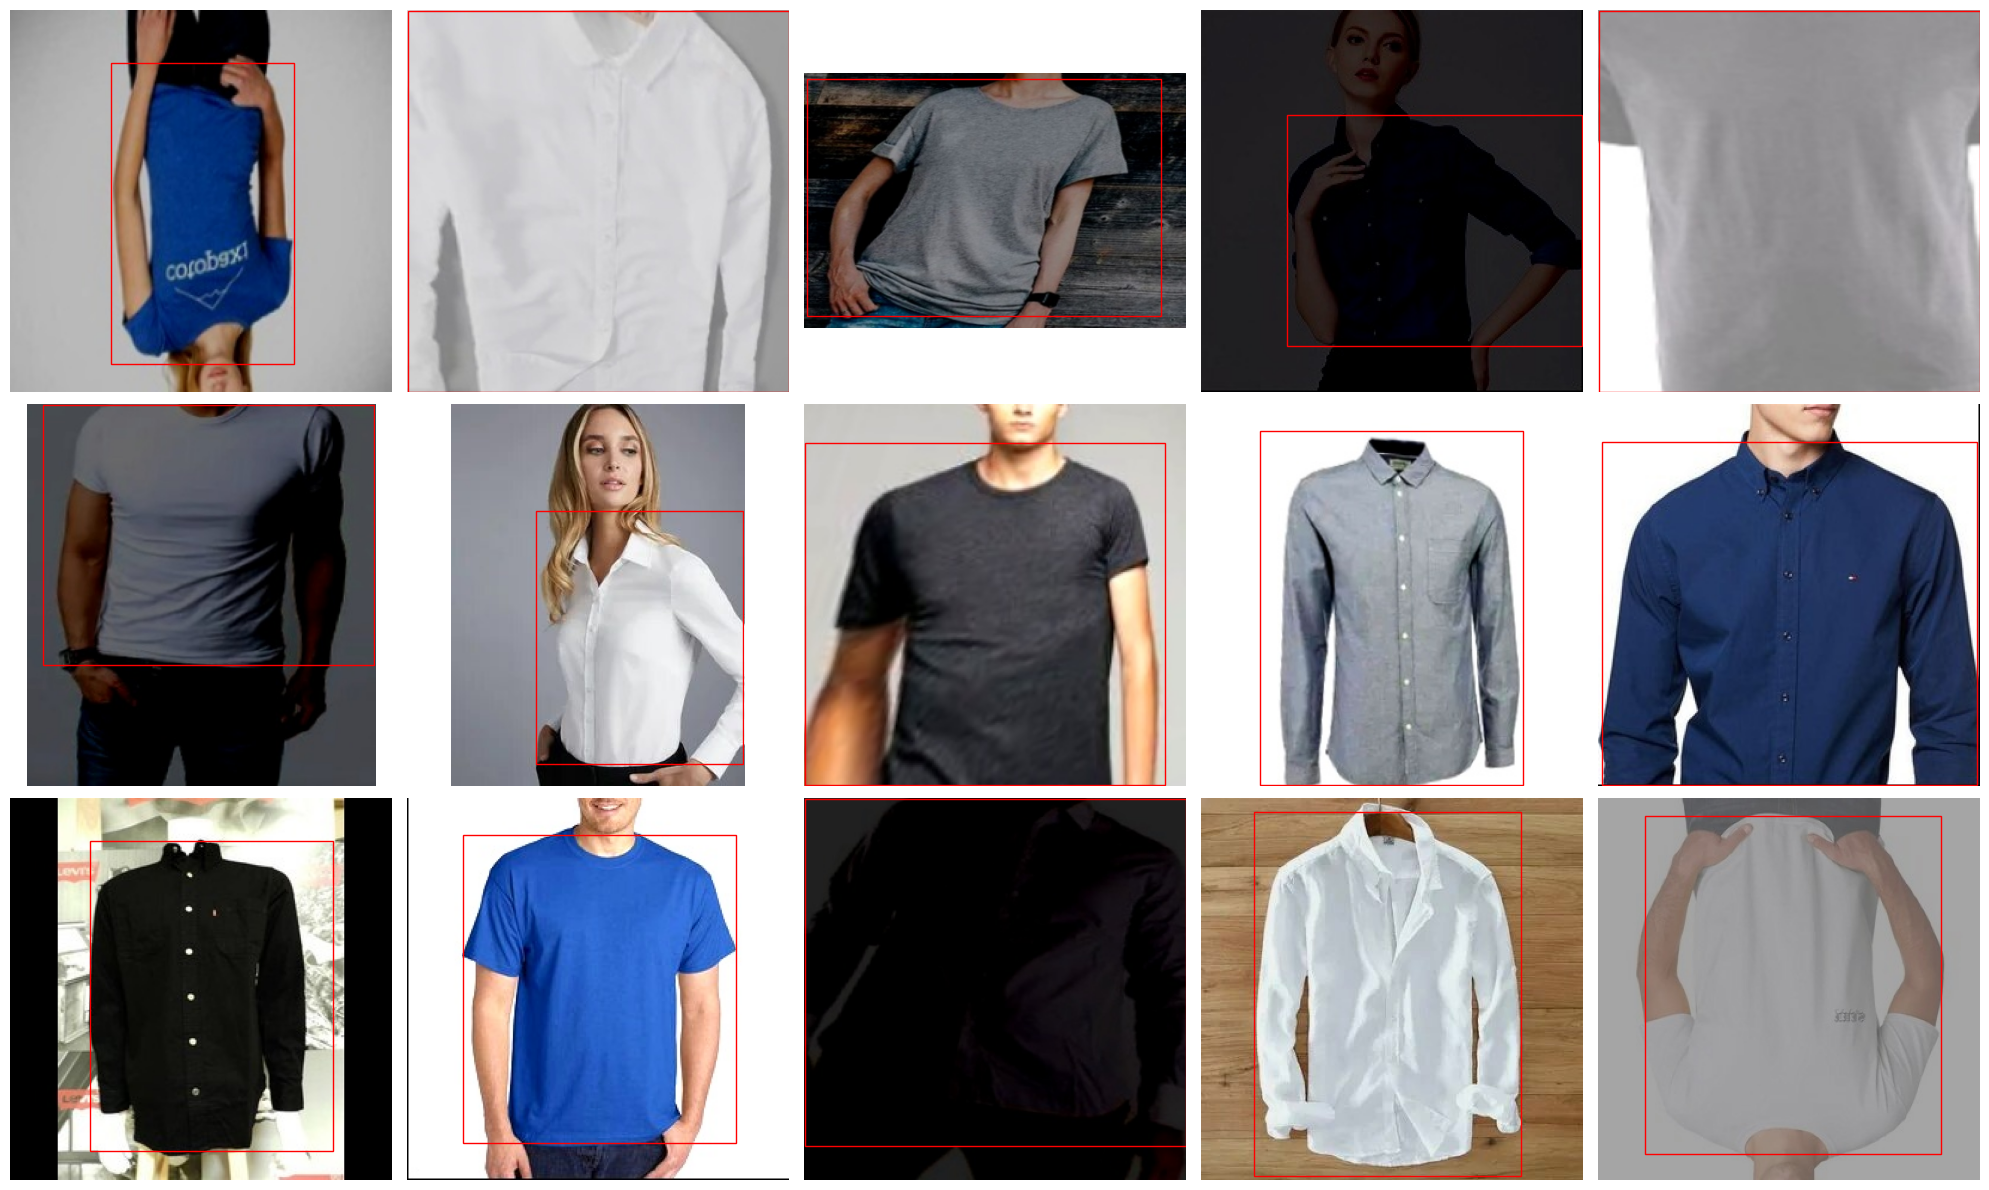

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from glob import glob
from random import sample

def plot_image_with_bboxes(ax, image, bboxes):
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for bbox in bboxes:
        x_center, y_center, width, height, class_id = bbox
        # Convert from relative to absolute coordinates
        x_min = int((x_center - width / 2) * image.shape[1])
        y_min = int((y_center - height / 2) * image.shape[0])
        rect_width = int(width * image.shape[1])
        rect_height = int(height * image.shape[0])

        rect = patches.Rectangle((x_min, y_min), rect_width, rect_height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.axis('off')  # Hide the axes

# Paths to your augmented images and labels
images_path = '/content/augmented1/images/train'
labels_path = '/content/augmented1/labels/train'

# Collect all image files
image_files = glob(os.path.join(images_path, '*.*'))  # Wildcard for all extensions

# Randomly select 15 images
sample_images = sample(image_files, 15)

# Set up the subplot grid
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  # Adjust figsize as needed
axes = axes.flatten()

for i, image_path in enumerate(sample_images):
    # Load image
    image = cv2.imread(image_path)

    # Check if the image was loaded properly
    if image is None:
        print(f"Error loading image: {image_path}")
        continue

    # Load corresponding label
    label_name = os.path.splitext(os.path.basename(image_path))[0] + '.txt'
    label_path = os.path.join(labels_path, label_name)

    bboxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                bboxes.append([x_center, y_center, width, height, int(class_id)])

    # Plot image with bounding boxes
    plot_image_with_bboxes(axes[i], image, bboxes)

# Hide any unused subplots
for j in range(len(sample_images), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import os

def count_images_in_folder(folder_path, image_extensions):
    # Initialize count
    image_count = 0

    # Iterate through all files in the folder
    for file_name in os.listdir(folder_path):
        # Check if the file has an image extension
        if any(file_name.lower().endswith(ext) for ext in image_extensions):
            image_count += 1

    return image_count

# Define the path to your folder and the image extensions to look for
folder_path = '/content/augmented1/images/train'
image_extensions = ['.jpg', '.jpeg', '.png', '.webp']

# Get the count of images
num_images = count_images_in_folder(folder_path, image_extensions)

print(f"Number of images in the folder: {num_images}")

Number of images in the folder: 512


In [ ]:
ROOT_DIR = '/content/'

In [ ]:
import os

from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.yaml')

# Use the model
results = model.train(data=os.path.join(ROOT_DIR, "shirts.yaml"), epochs=20)

Ultralytics YOLOv8.2.69 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/shirts.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

train: Scanning /content/augmented1/labels/train... 512 images, 0 backgrounds, 0 corrupt: 100%|██████████| 512/512 [00:00<00:00, 1591.83it/s]

train: New cache created: /content/augmented1/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/shirts/labels/val.cache... 32 images, 0 backgrounds, 0 corrupt: 100%|██████████| 32/32 [00:00<?, ?it/s]


Plotting labels to runs/detect/train10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train10
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.74G      2.953      3.889      4.151         39        640: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         32         32    0.00302      0.906    0.00919    0.00403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.28G       2.81      3.704      3.884         38        640: 100%|██████████| 32/32 [00:07<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         32         32    0.00302      0.906     0.0522     0.0132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.25G      2.529      3.637      3.518         48        640: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         32         32    0.00346      0.844     0.0668      0.017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.25G      2.273       3.45      3.201         41        640: 100%|██████████| 32/32 [00:08<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         32         32    0.00354      0.938      0.102     0.0339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.25G      2.164      3.285      2.975         48        640: 100%|██████████| 32/32 [00:09<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         32         32      0.834      0.125       0.23     0.0857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.25G      2.092      3.183      2.841         42        640: 100%|██████████| 32/32 [00:10<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]

                   all         32         32      0.842      0.188      0.177     0.0703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.25G      1.939      2.951      2.685         43        640: 100%|██████████| 32/32 [00:07<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         32         32      0.296      0.375       0.43      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.25G      1.815       2.85      2.527         43        640: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         32         32      0.307      0.134      0.211     0.0899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.25G       1.74      2.698      2.445         57        640: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         32         32      0.296      0.463       0.44      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.25G      1.683      2.572      2.358         47        640: 100%|██████████| 32/32 [00:09<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         32         32      0.442      0.356      0.474      0.282


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.39G      1.387      2.684      2.364         16        640: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         32         32      0.402      0.651      0.544       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.25G      1.246        2.3      2.178         16        640: 100%|██████████| 32/32 [00:07<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         32         32      0.448       0.63      0.662       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.25G      1.201      2.114      2.123         16        640: 100%|██████████| 32/32 [00:11<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         32         32       0.55      0.719      0.688      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.25G      1.134      1.966      2.033         16        640: 100%|██████████| 32/32 [00:07<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         32         32      0.678      0.781      0.775      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.25G      1.091      1.856      2.027         16        640: 100%|██████████| 32/32 [00:09<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         32         32      0.651      0.811      0.773       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.25G      1.061        1.8      1.941         16        640: 100%|██████████| 32/32 [00:08<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         32         32      0.781      0.728      0.785      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.25G     0.9986      1.761      1.896         16        640: 100%|██████████| 32/32 [00:08<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         32         32      0.653      0.825      0.824       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.25G     0.9553      1.701      1.808         16        640: 100%|██████████| 32/32 [00:09<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         32         32      0.563      0.844      0.847      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.25G     0.9308      1.646      1.807         16        640: 100%|██████████| 32/32 [00:07<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         32         32      0.697      0.812      0.842      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.25G     0.9162      1.581      1.799         16        640: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         32         32      0.788       0.75      0.845      0.649



20 epochs completed in 0.062 hours.
Optimizer stripped from runs/detect/train10/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train10/weights/best.pt, 6.2MB

Validating runs/detect/train10/weights/best.pt...
Ultralytics YOLOv8.2.69 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]


                   all         32         32      0.672      0.896       0.85       0.65
           Black_Shirt          8          8      0.603          1      0.954      0.771
            Blue_Shirt          8          8      0.891          1      0.995      0.786
           White_Shirt          8          8      0.885      0.963      0.967      0.712
            Grey_Shirt          8          8      0.312      0.622      0.484      0.333
Speed: 0.2ms preprocess, 1.9ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train10
